# Evaluate ASR algorithm in motion artifacts removal

In [42]:
import glob
import numpy as np
import pandas as pd
import scipy.fftpack    
import seaborn as sns
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.integrate import cumtrapz
from utils.signal_processing import filter_sos, filter_iir

## Custom parameters

In [43]:
# Sampling rate and window length
fs = 250
eeg_chans = 1
demo_interval = 10*fs

##  Local Functions

In [44]:
def compute_vector_sum(accel_x_filtered=None, accel_y_filtered=None, accel_z_filtered=None):
    return np.sqrt(accel_x_filtered**2 + accel_y_filtered**2 + accel_z_filtered**2).tolist()

def min_max_scaling_to_eeg(imu_data, eeg_data):
    eeg_min = np.min(eeg_data)
    eeg_max = np.max(eeg_data)
    imu_min = np.min(imu_data)
    imu_max = np.max(imu_data)
    scaled_imu_data = (imu_data - imu_min) / (imu_max - imu_min) * (eeg_max - eeg_min) + eeg_min
    return scaled_imu_data

def z_score_normalize(sig):
    signal=sig.copy()
    mean = np.mean(signal)
    std = np.std(signal)
    normalized_signal = (signal - mean) / std
    return normalized_signal, (mean, std)

def convert_back_to_original_scale(processed_signal, params):
    mean, std = params
    original_scale_signal = processed_signal * std + mean
    return original_scale_signal

from skimage.restoration import estimate_sigma

def universal_threshold(signal):
    N = len(signal)
    sigma = estimate_sigma(signal, average_sigmas=True)
    thresh = sigma * np.sqrt(2 * np.log(N))
    return thresh

## Read data from all required files

In [45]:
file_names = sorted(glob.glob('./data/logging/IMU_Pannel_both_1/CONVERTED_*'))
data1 = pd.concat([pd.read_csv(file_name, sep='\t') for file_name in file_names])
data1 = data1.drop(columns=['index', 'time stamp', 'Stage'])

file_names = sorted(glob.glob(f'./data/logging/IMU_Pannel_Rotate_2/CONVERTED_*'))
data2 = pd.concat([pd.read_csv(file_name, sep='\t') for file_name in file_names])
data2 = data2.drop(columns=['index', 'time stamp', 'Stage'])

data = pd.concat([
                    data1 
                    ,data2 
                    # ,data3
                  ])

In [46]:
len1 = len(data1)
len2 = len(data2)

## Channel name and channel labels

In [47]:
channel_names = ['Fp2', 'Fp1', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'accel']    
channel_labels = ['uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'V/1024', 'BPM', 'g (1g = 9.8m/s^2)'] 

stim_idx = len1 + 10*fs
post_stim_idx = stim_idx + 7488

## Filter the data

In [48]:
filtered_data = []
for i in range(data.shape[1]):
    column_data = data.iloc[:, i].to_numpy().copy()
    # 7 channels
    if i < 6:        
        column_data, _ = filter_sos(column_data, 'bandpass', [0.5, 40.0], fs, 4)
        column_data, _ = filter_sos(column_data, 'notch', 50.0, fs, 2, notchWidth=4)
        column_data, _ = filter_sos(column_data, 'notch', 60.0, fs, 2, notchWidth=4)
        # column_data = filter_iir(column_data, 'bandpass', [1, 40.0], fs, 4)
        # column_data = filter_iir(column_data, 'notch', 50.0, fs, 2, notch_width=4)
        # column_data = filter_iir(column_data, 'notch', 60.0, fs, 2, notch_width=4)
        
    if i == 6:
        column_data, _ = filter_sos(column_data, 'bandpass', [5, 40.0], fs, 4)
        column_data, _ = filter_sos(column_data, 'notch', 50.0, fs, 2, notchWidth=4)
        column_data, _ = filter_sos(column_data, 'notch', 60.0, fs, 2, notchWidth=4)
        
        b, a = signal.butter(4, 50/(fs/2), 'low')
        tempf = signal.filtfilt(b,a, column_data)
        tempf = signal.filtfilt(b,a, column_data)
        yff = scipy.fftpack.fft(tempf)

        nyq_rate = fs/ 2.0
        width = 5.0/nyq_rate
        ripple_db = 60.0
        O, beta = signal.kaiserord(ripple_db, width)
        cutoff_hz = 4.0
        taps = signal.firwin(O, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
        # Use lfilter to filter x with the FIR filter.
        column_data = signal.lfilter(taps, 1.0, tempf)

    filtered_data.append(column_data)
    
vector_sum = compute_vector_sum(filtered_data[8], filtered_data[9], filtered_data[10])
filtered_data.append(vector_sum)
filtered_data = np.array(filtered_data)

## Extract the IMU features

In [49]:
motion_artifacts = []

for i in range(8, 11):
    # filtered, _ = filter_sos(filtered_data[i], 'bandpass', [1, 20.0], fs, 4)
    # motion_artifacts.append(filtered)
    
    filtered = filter_iir(filtered_data[i], 'bandpass', [0.5, 20.0], fs, 4)
    motion_artifacts.append(filtered)
    
    # process_data = filtered_data[i]
    # process_data = filter_iir(process_data, fs, [1, 40], order=4)
    # motion_artifacts.append(process_data)
    
sum_square_ma = compute_vector_sum(motion_artifacts[0], motion_artifacts[1], motion_artifacts[2])

dt = 1/fs
velocity = [cumtrapz(y=a, dx=dt, initial=0) for a in motion_artifacts]
velocity = np.array(velocity)
sum_square_velocity = compute_vector_sum(velocity[0], velocity[1], velocity[2])

imu_features = np.array([velocity[0], 
                            velocity[1], 
                            velocity[2], 
                            motion_artifacts[0], 
                            motion_artifacts[1], 
                            motion_artifacts[2], 
                            sum_square_velocity,
                            sum_square_ma])

imu_labels = ['Vel-X', 'Vel-Y', 'Vel-Z', 'Accel-X', 'Accel-Y', 'Accel-Z', 'Vel-Square', 'Accel-Square']

C:\Users\Nhan\AppData\Local\Temp\ipykernel_63496\3906135439.py:17: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity = [cumtrapz(y=a, dx=dt, initial=0) for a in motion_artifacts]


Extract the stim interval of both eeg and IMU

In [50]:
eeg_stim = filtered_data[:2, stim_idx:post_stim_idx]
imu_stim = imu_features[:, stim_idx:post_stim_idx]

Calculate the correlation between the IMU features and the contaminated channel Fp2

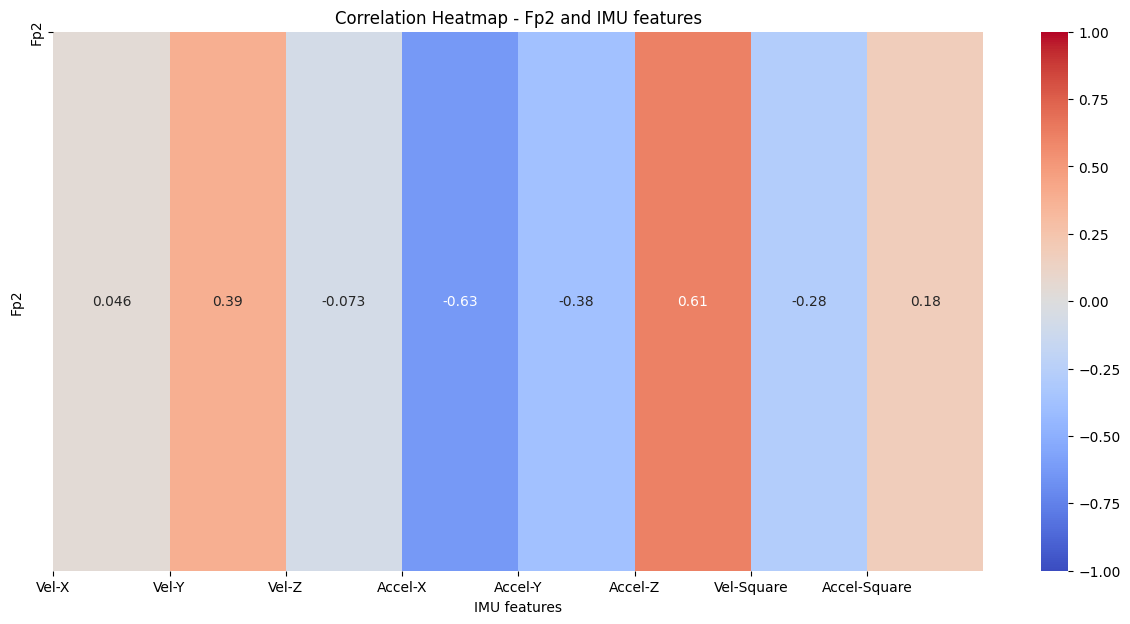

In [51]:
corr_fp2_imu = np.zeros((eeg_chans, imu_features.shape[0]))

for i in range(corr_fp2_imu.shape[0]):
    for j in range(corr_fp2_imu.shape[1]):
        corr_fp2_imu[i, j] = np.corrcoef(eeg_stim[i], imu_stim[j])[0, 1]
        
plt.figure(figsize=(15, 7))
sns.heatmap(corr_fp2_imu, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Fp2 and IMU features')
plt.xlabel('IMU features')
plt.ylabel('Fp2')
plt.xticks(np.arange(0, corr_fp2_imu.shape[1]), labels=imu_labels)
plt.yticks(np.arange(0, corr_fp2_imu.shape[0]), labels=['Fp2'])
plt.show()

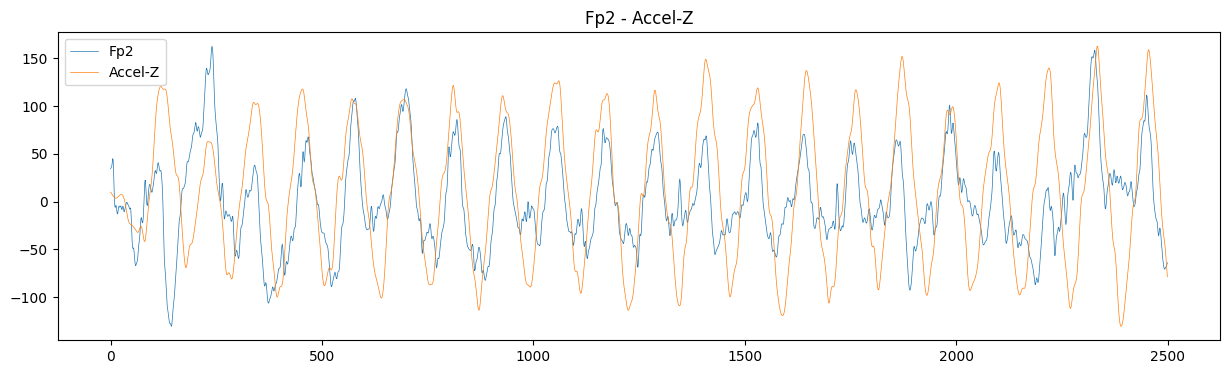

In [52]:
selected_featuresa = [5]

for i in range(eeg_chans):
    for j in selected_featuresa:
        plt.figure(figsize=(15, 4))    
        eeg_plot = eeg_stim[i,:demo_interval]
        imu_plot = min_max_scaling_to_eeg(imu_stim[j,:demo_interval], eeg_plot)

        plt.plot(eeg_plot, linewidth=0.5, label='Fp2')
        plt.plot(imu_plot, linewidth=0.5 ,label=imu_labels[j])
        plt.title(f'Fp2 - {imu_labels[j]}') 
        plt.legend()

## Apply the cross-correlation to fix the phase shift between EEG and IMU signals

In [53]:
# Cross-correlation and lag identification
lags = []
correlations = []

for i in range(imu_features.shape[0]):
    correlation = correlate(eeg_stim[0], imu_stim[i], mode='full')
    corr_length = len(correlation)    
    lagss = np.arange(-corr_length//2, corr_length//2 + 1)
    max_corr_index = np.argmax(correlation)
    lag = lagss[max_corr_index]
    
    lags.append(lag)
    correlations.append(correlation)

print('Lags between Fp2 and VelX: ', lags[0])
print('Lags between Fp2 and VelY: ', lags[1])
print('Lags between Fp2 and VelZ: ', lags[2])
print('Lags between Fp2 and AccX: ', lags[3])
print('Lags between Fp2 and AccY: ', lags[4])
print('Lags between Fp2 and AccZ: ', lags[5])
print('Lags between Fp2 and Vel-Square: ', lags[6])
print('Lags between Fp2 and Acc-Squre: ', lags[7])

Lags between Fp2 and VelX:  26
Lags between Fp2 and VelY:  -103
Lags between Fp2 and VelZ:  -147
Lags between Fp2 and AccX:  -176
Lags between Fp2 and AccY:  -77
Lags between Fp2 and AccZ:  -119
Lags between Fp2 and Vel-Square:  80
Lags between Fp2 and Acc-Squre:  52


## Corect the phase shift

In [54]:
def adjust_imu_feature(imu_feature, lag_value):
    if lag_value > 0:
        adjusted_feature = np.concatenate((np.zeros(lag_value), imu_feature))[:-lag_value]
    elif lag_value < 0:
        adjusted_feature = np.concatenate((imu_feature[abs(lag_value):], np.zeros(abs(lag_value))))
    else:
        adjusted_feature = imu_feature
    return adjusted_feature

imu_fixed_lags = np.array([adjust_imu_feature(imu_feature, lag) for imu_feature, lag in zip(imu_stim, lags)])

## Re-calculate the Pearson correlation coefficient and visualize the correction

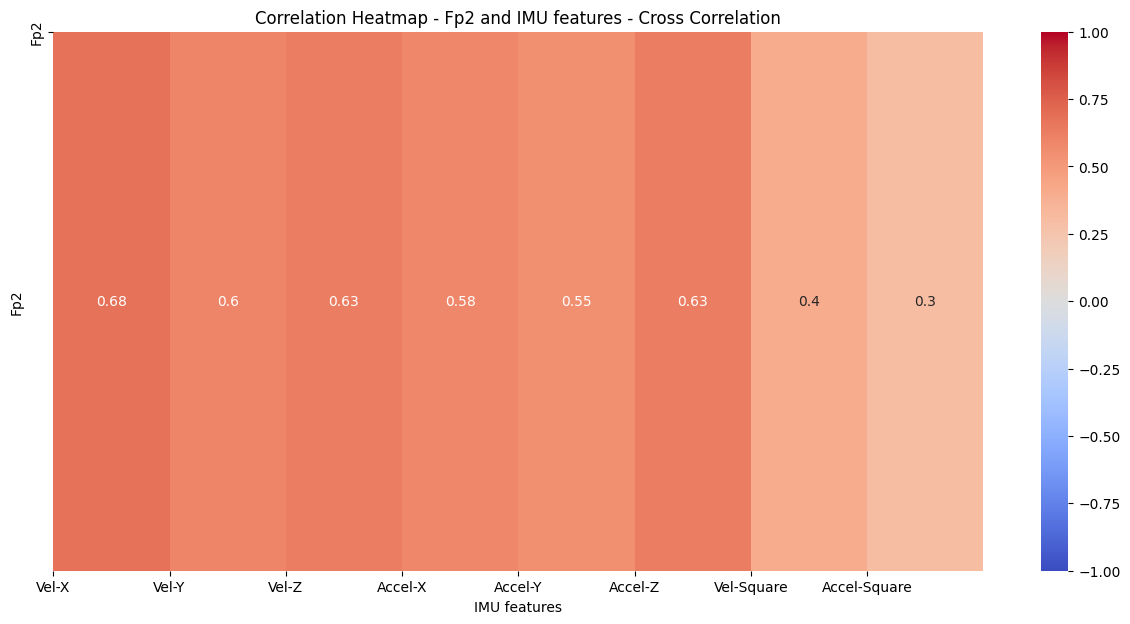

In [55]:
corr_mat_fp2_imu = np.zeros((eeg_chans, imu_fixed_lags.shape[0]))

for i in range(corr_mat_fp2_imu.shape[0]):
    for j in range(corr_mat_fp2_imu.shape[1]):
        corr_mat_fp2_imu[i, j] = np.corrcoef(eeg_stim[0], imu_fixed_lags[j])[0, 1]
        
# Visualize the correlation map
plt.figure(figsize=(15, 7))
sns.heatmap(corr_mat_fp2_imu, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Fp2 and IMU features - Cross Correlation')
plt.xlabel('IMU features')
plt.ylabel('Fp2')
plt.xticks(np.arange(0, corr_mat_fp2_imu.shape[1]), labels=imu_labels)
plt.yticks(np.arange(0, corr_mat_fp2_imu.shape[0]), labels=['Fp2'])
plt.show()

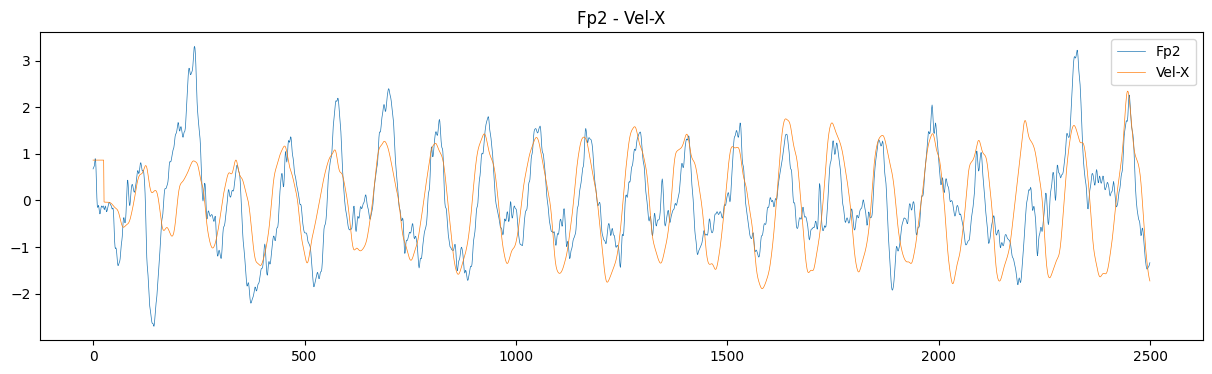

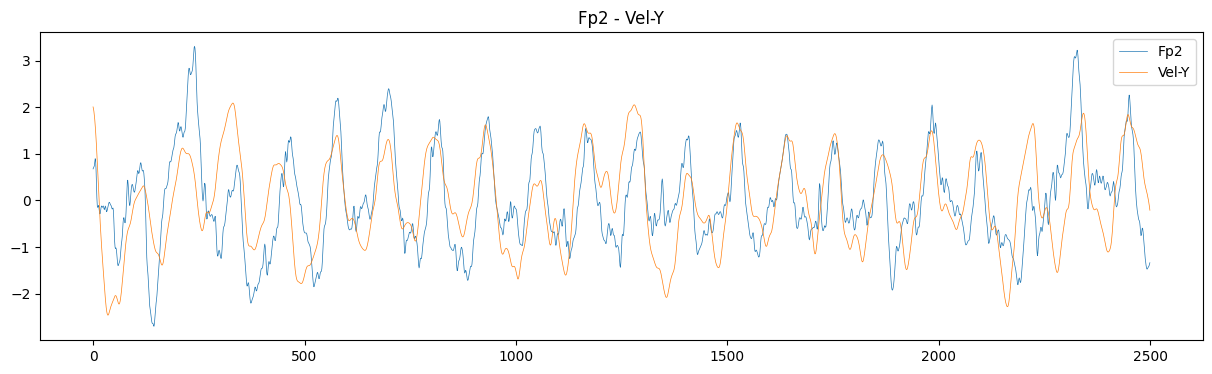

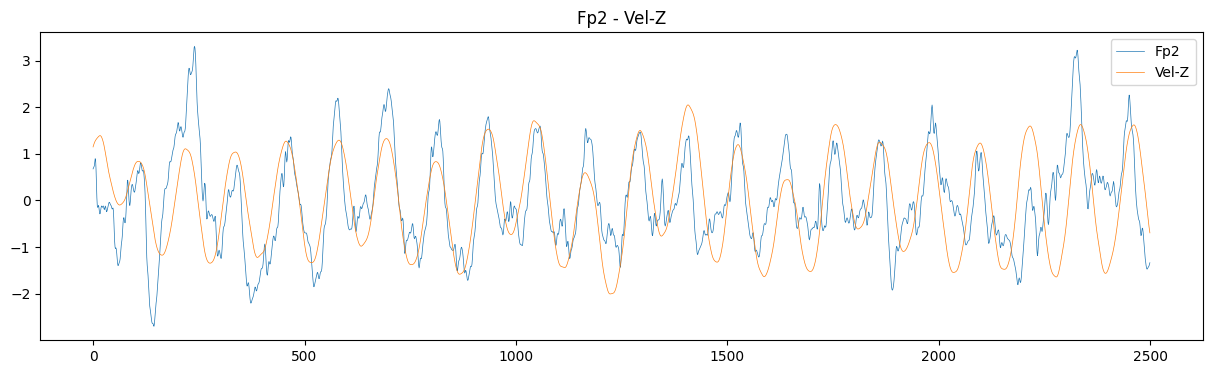

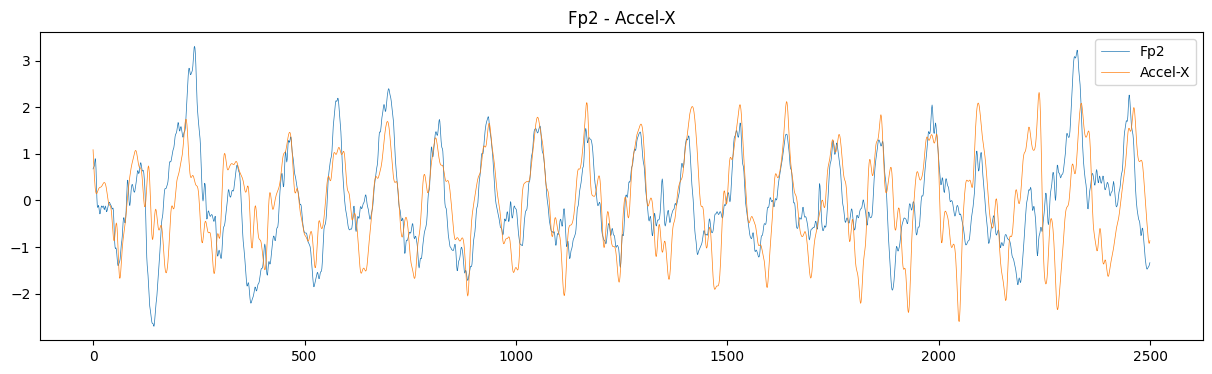

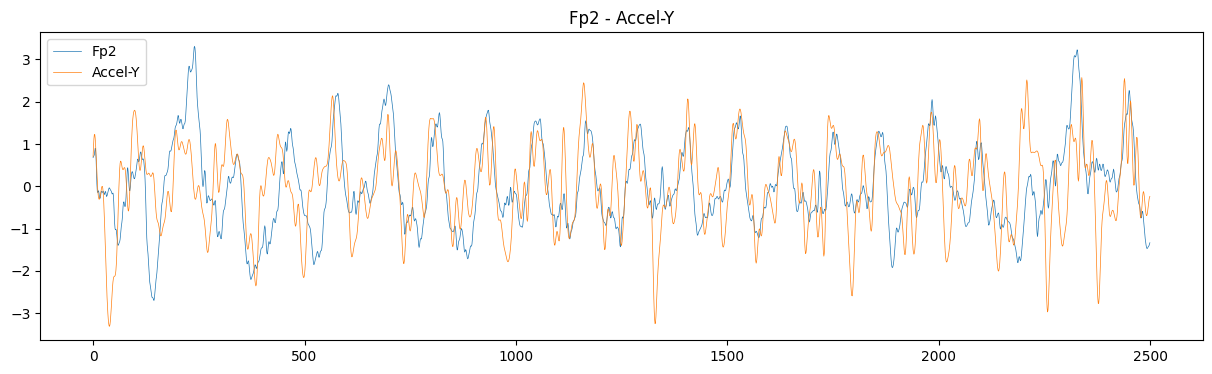

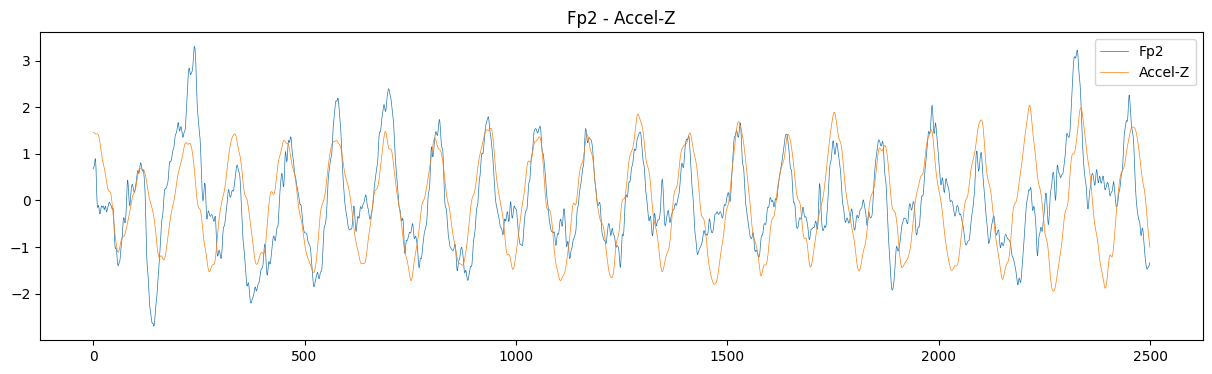

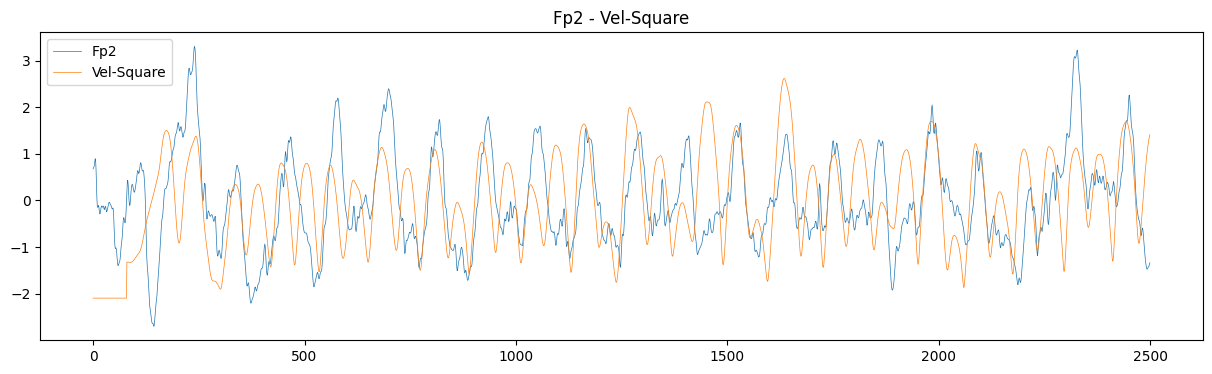

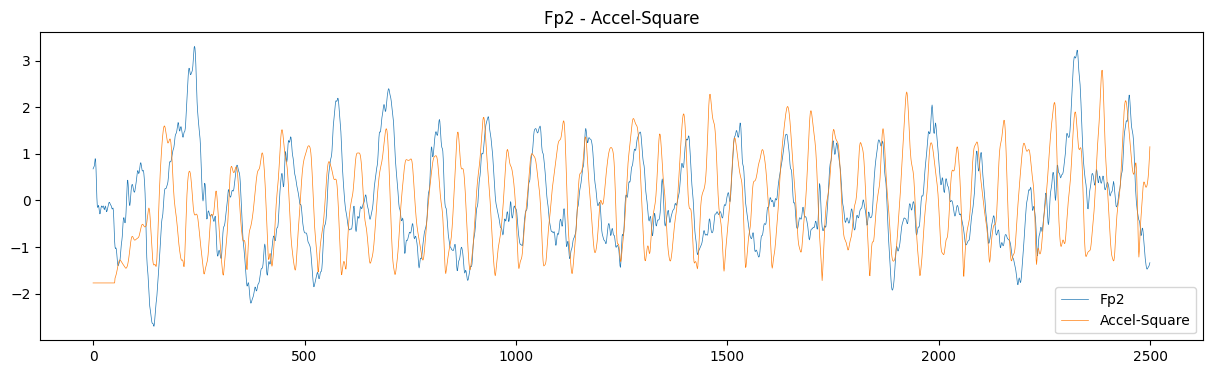

In [56]:
for i in range(eeg_chans):
    for j in range(imu_fixed_lags.shape[0]):
        plt.figure(figsize=(15, 4))    

        eeg_plot, _ = z_score_normalize(eeg_stim[0,:demo_interval])
        imu_plot, _ = z_score_normalize(imu_fixed_lags[j,:demo_interval])

        plt.plot(eeg_plot, linewidth=0.5, label='Fp2')
        plt.plot(imu_plot, linewidth=0.5 ,label=imu_labels[j])
        plt.title(f'Fp2 - {imu_labels[j]}') 

        plt.legend()

## Apply ASR on single channel with EEG as clean reference signal

In [57]:
# This is for the calibration using clean EEG signals
cal_start_idx = 10*fs
cal_stop_idx = 70*fs

Depcompose the single EEG channel and the IMU feature first

In [83]:
import pywt

wavelet = 'db4'
decomposition_level = 5
asr_single = filtered_data.copy()

# Further high-pass filtering due to the recommendation from the article 
clean_fp2, _ = filter_sos(asr_single[0], 'bandpass', [5, 40.0], fs, 4)
asr_single[1], _ = filter_sos(asr_single[1], 'bandpass', [5, 40.0], fs, 4)
# asr_single[0], _ = filter_sos(asr_single[0], 'bandpass', [5, 40.0], fs, 4)

# Perform Wavelet Transform on both reference and EEG data to decompose them
ref_swt = imu_fixed_lags[:1]
eeg_swt = asr_single[:eeg_chans, stim_idx:post_stim_idx]

eeg_dat_z, eeg_data_zparams = z_score_normalize(eeg_swt)
ref_dat_z, swt_ref_zparams = z_score_normalize(ref_swt)
ref_dat_z = convert_back_to_original_scale(ref_dat_z, eeg_data_zparams)


coeffs_ref_swt = [pywt.swt(ref_dat_z[i], wavelet, level=decomposition_level) for i in range(ref_swt.shape[0])] 
coeffs_eeg_swt = [pywt.swt(eeg_swt[i], wavelet, level=decomposition_level) for i in range(eeg_swt.shape[0])]

print(ref_dat_z.shape)

(1, 7488)


Visualize the coefficients first

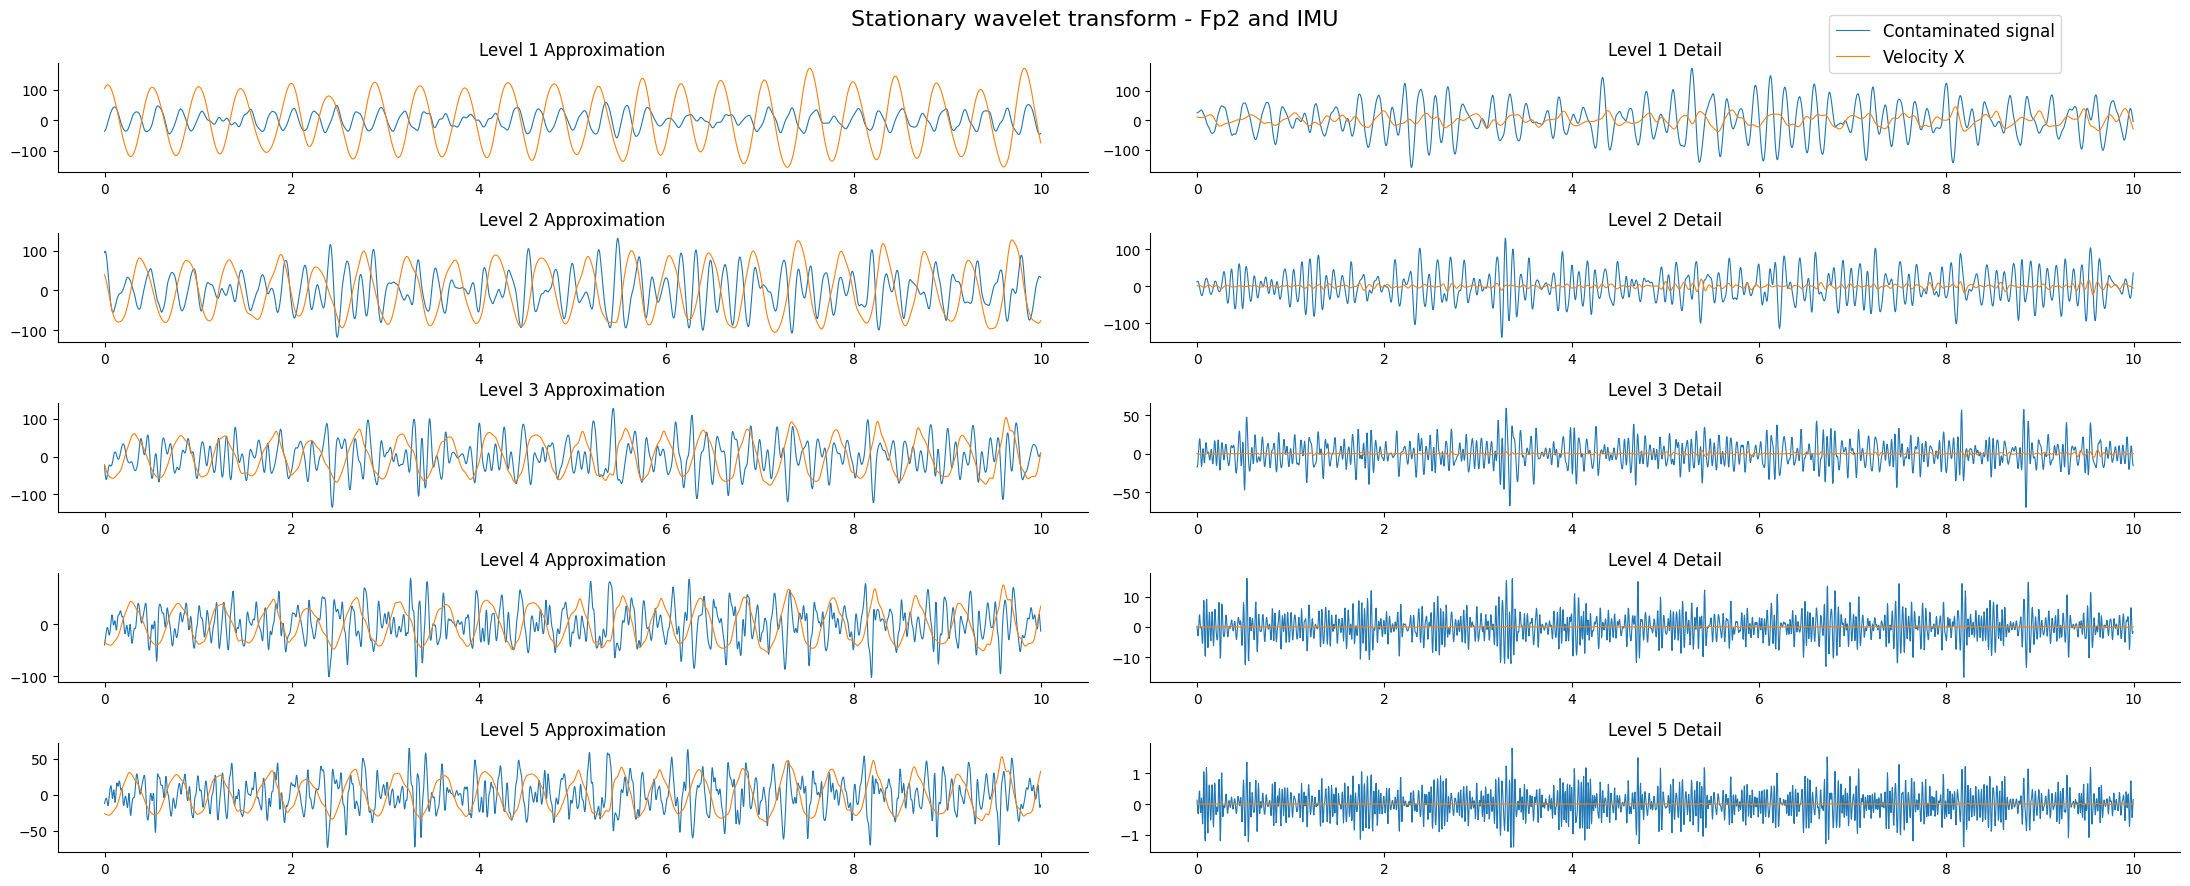

In [59]:
fig, axs = plt.subplots(decomposition_level, 2, figsize=(22, 9))
fig.suptitle('Stationary wavelet transform - Fp2 and IMU', fontsize=16)
timex = np.arange(2500)/fs

for level in range(decomposition_level):
    # Plotting EEG and IMU approximations
    line1, = axs[level, 0].plot(timex, coeffs_eeg_swt[0][level][0][2500:5000], linewidth=0.8, label='EEG Approx')
    line2, = axs[level, 0].plot(timex, coeffs_ref_swt[0][level][0][2500:5000], linewidth=0.8, label='IMU Approx')
    axs[level, 0].set_title(f'Level {level + 1} Approximation')

    # Removing right and top lines, adjusting ticks for subplot [level, 0]
    axs[level, 0].spines['right'].set_visible(False)
    axs[level, 0].spines['top'].set_visible(False)
    axs[level, 0].yaxis.set_ticks_position('left')
    axs[level, 0].xaxis.set_ticks_position('bottom')

    # Plotting EEG and IMU details
    line3, = axs[level, 1].plot(timex, coeffs_eeg_swt[0][level][1][2500:5000], linewidth=0.8, label='EEG Detail')
    line4, = axs[level, 1].plot(timex, coeffs_ref_swt[0][level][1][2500:5000], linewidth=0.8, label='IMU Detail')
    axs[level, 1].set_title(f'Level {level + 1} Detail')

    # Removing right and top lines, adjusting ticks for subplot [level, 1]
    axs[level, 1].spines['right'].set_visible(False)
    axs[level, 1].spines['top'].set_visible(False)
    axs[level, 1].yaxis.set_ticks_position('left')
    axs[level, 1].xaxis.set_ticks_position('bottom')

# Create a legend with custom handles
handles = [line1, line2, line3, line4]
labels = ['Contaminated signal', 'Velocity X']
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.83, 0.9), fontsize=12)

plt.savefig(f'figures/swt_decomposition.svg', format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

Apply ASR on the coefficients

In [60]:
from meegkit.asr import ASR

window_size = 7488  # 500ms window in samples

eeg_detail_asrs = []
eeg_approx_asrs = []

for i in range(eeg_chans):
    coeffs_ref = np.array(coeffs_ref_swt[i])
    coeffs_eeg = np.array(coeffs_eeg_swt[i])
    
    # Extract approximation coefficients and detail coefficients of the ref signal
    ref_approx_coeffs = coeffs_ref[:, 0, :]
    ref_detail_coeffs = coeffs_ref[:, 1, :]

    # Extract approximation coefficients and detail coefficients of the eeg signal
    eeg_approx_coeffs = coeffs_eeg[:, 0, :]
    eeg_detail_coeffs = coeffs_eeg[:, 1, :]

    eeg_detail_asr = eeg_detail_coeffs.copy()
    ref_detail_asr = ref_detail_coeffs.copy()

    eeg_approx_asr = eeg_approx_coeffs.copy()
    ref_approx_asr = ref_approx_coeffs.copy()

    # We need to tune the ASR carefully in this case
    asr = ASR(sfreq=fs, method='rieman', estimator='lwf', win_overlap=0.66, cutoff=20)   
    _, sample_mask = asr.fit(ref_detail_coeffs)        

    # Iterate through the entire data to remove motion artifacts if any
    for idx in range(0, eeg_detail_coeffs.shape[1], window_size):        
        bad_data = eeg_detail_coeffs[:, idx:idx+window_size]        
        clean_data, artifacts = asr.transform(bad_data)
        eeg_detail_asr[:, idx:idx+window_size] = artifacts
        
    eeg_detail_asrs.append(eeg_detail_asr)

    # We need to tune the ASR carefully in this case
    asr = ASR(sfreq=fs, method='rieman', estimator='lwf', win_overlap=0.66, cutoff=20)   
    _, sample_mask = asr.fit(ref_approx_coeffs)        

    # Iterate through the entire data to remove motion artifacts if any
    for idx in range(0, eeg_approx_coeffs.shape[1], window_size):        
        bad_data = eeg_approx_coeffs[:, idx:idx+window_size]        
        clean_data, artifacts = asr.transform(bad_data)
        eeg_approx_asr[:, idx:idx+window_size] = artifacts
        
    eeg_approx_asrs.append(eeg_approx_asr)

Re-construct the clean signal from the SWT using SWT inverse

In [61]:
clean_eeg_single_asr = []

for j in range(eeg_chans):
    coeffs_for_reconstruction = [(eeg_approx_asrs[j][i], eeg_detail_asrs[j][i]) for i in range(eeg_approx_asrs[j].shape[0])]
    # coeffs_for_reconstruction = [(eeg_detail_asrs[j][i]) for i in range(eeg_approx_asrs[j].shape[0])]

    clean_eeg_single_asr.append(pywt.iswt(coeffs_for_reconstruction, wavelet))


Visulize this inverse result for Fp2

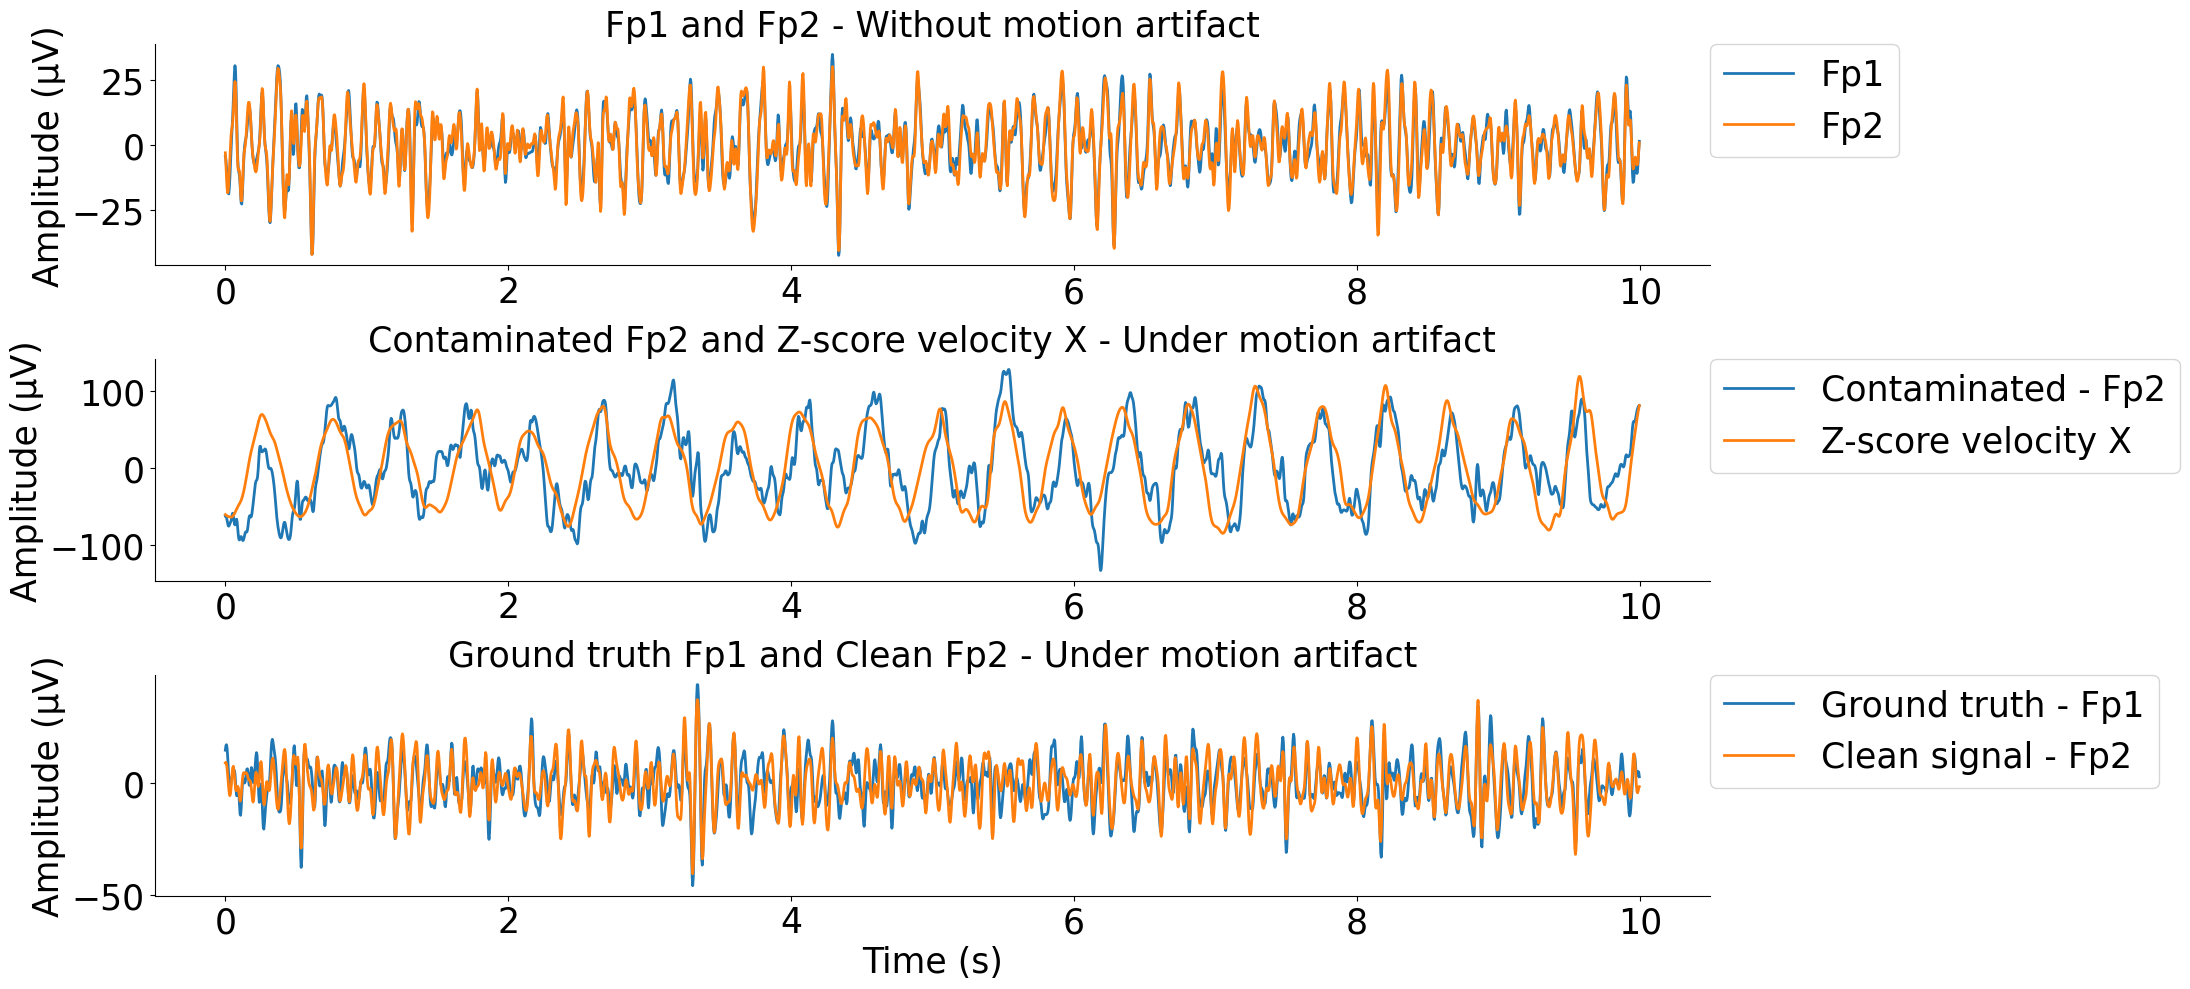

In [84]:
z1_single_asr, ground_truth_z_revert = z_score_normalize(asr_single[1, stim_idx+10*fs:stim_idx+20*fs])
z2_single_asr, _ = z_score_normalize(clean_eeg_single_asr[0][10*fs:20*fs])
clean = convert_back_to_original_scale(clean_eeg_single_asr[0][10*fs:20*fs], ground_truth_z_revert)
z3_single_asr, contaminated_z_revert = z_score_normalize(asr_single[0, stim_idx+10*fs:stim_idx+20*fs])

# Time vector for x-axis
timex = np.arange(len(clean))/fs

# Create a figure and axes
fig, axs = plt.subplots(3, 1, figsize=(22, 10))  # figsize as per subplot needs

axs[0].plot(timex, asr_single[1, cal_start_idx+20*fs:cal_start_idx+30*fs], linewidth=2, label='Fp1')
axs[0].plot(timex, clean_fp2[cal_start_idx+20*fs:cal_start_idx+30*fs], linewidth=2, label='Fp2')
axs[0].set_ylabel("Amplitude (µV)", fontsize=25)
axs[0].set_title("Fp1 and Fp2 - Without motion artifact", fontsize=25)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].yaxis.set_ticks_position('left')
axs[0].xaxis.set_ticks_position('bottom')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=25)  # Adjusted position
axs[0].tick_params(axis='both', labelsize=25)  # Adjust the size as needed

axs[1].plot(timex, filtered_data[0, stim_idx+10*fs:stim_idx+20*fs], linewidth=2, label='Contaminated - Fp2')
axs[1].plot(timex, ref_dat_z[0, 10*fs:20*fs], linewidth=2, label='Z-score velocity X')
axs[1].set_ylabel("Amplitude (µV)", fontsize=25)
axs[1].set_title("Contaminated Fp2 and Z-score velocity X - Under motion artifact", fontsize=25)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].yaxis.set_ticks_position('left')
axs[1].xaxis.set_ticks_position('bottom')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=25)  # Adjusted position
axs[1].tick_params(axis='both', labelsize=25)  # Adjust the size as needed

# Second subplot for Ground Truth - Fp1
axs[2].plot(timex, asr_single[1, stim_idx+10*fs:stim_idx+20*fs], linewidth=2, label='Ground truth - Fp1')
axs[2].plot(timex, clean_eeg_single_asr[0][10*fs:20*fs], linewidth=2, label='Clean signal - Fp2')
axs[2].set_xlabel("Time (s)", fontsize=25)
axs[2].set_ylabel("Amplitude (µV)", fontsize=25)
axs[2].set_title("Ground truth Fp1 and Clean Fp2 - Under motion artifact", fontsize=25)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[2].yaxis.set_ticks_position('left')
axs[2].xaxis.set_ticks_position('bottom')
axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=25)  # Adjusted position
axs[2].tick_params(axis='both', labelsize=25)  # Adjust the size as needed


# Save the figure
plt.tight_layout()
plt.savefig('figures/contaminated_groundtruth_clean.svg', format='svg', bbox_inches='tight')
plt.show()


In [63]:
ground_truth_fp1 = asr_single[1, stim_idx+10*fs:stim_idx+20*fs]
contaminated_fp2 = filtered_data[0, stim_idx+10*fs:stim_idx+20*fs]
cl_fp2 = clean_eeg_single_asr[0][10*fs:20*fs]

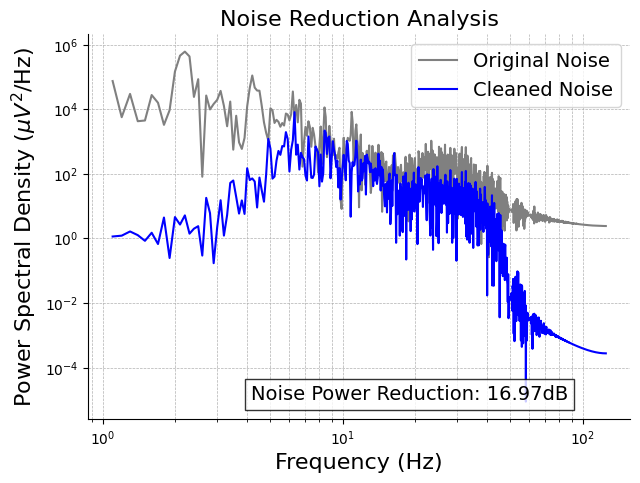

In [64]:
from scipy.fftpack import fft

# Calculate the noise in the original and cleaned signals
original_noise = contaminated_fp2 - ground_truth_fp1
cleaned_noise = cl_fp2 - ground_truth_fp1

# Compute the power spectral density of the noise
def power_spectral_density(signal):
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1/fs)  # Use the sampling frequency
    spectrum = np.abs(fft(signal))**2 / N
    # Filter frequencies to be greater than 1 Hz
    mask = freq > 1
    return freq[mask][:N // 2], spectrum[mask][:N // 2]

freq, original_psd = power_spectral_density(original_noise)
_, cleaned_psd = power_spectral_density(cleaned_noise)

# Compute noise reduction in dB
noise_reduction = 10 * np.log10(np.sum(original_psd) / np.sum(cleaned_psd))

# Plotting
plt.figure(figsize=(7, 5))
plt.loglog(freq, original_psd, label='Original Noise', color='grey')
plt.loglog(freq, cleaned_psd, label='Cleaned Noise', color='blue')
plt.title('Noise Reduction Analysis', fontsize=16)  # Increase title font size
plt.xlabel('Frequency (Hz)', fontsize=16)  # Increase x-label font size
plt.ylabel('Power Spectral Density ($\mu V^2$/Hz)', fontsize=16)  # Increase y-label font size
plt.legend(fontsize=14)  # Increase legend font size
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Hide the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Annotate the noise reduction
plt.annotate(f'Noise Power Reduction: {noise_reduction:.2f}dB', xy=(0.3, 0.05), xycoords='axes fraction', 
             fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
plt.savefig('figures/noise_reduction_analysis.svg', format='svg', bbox_inches='tight')

plt.show()


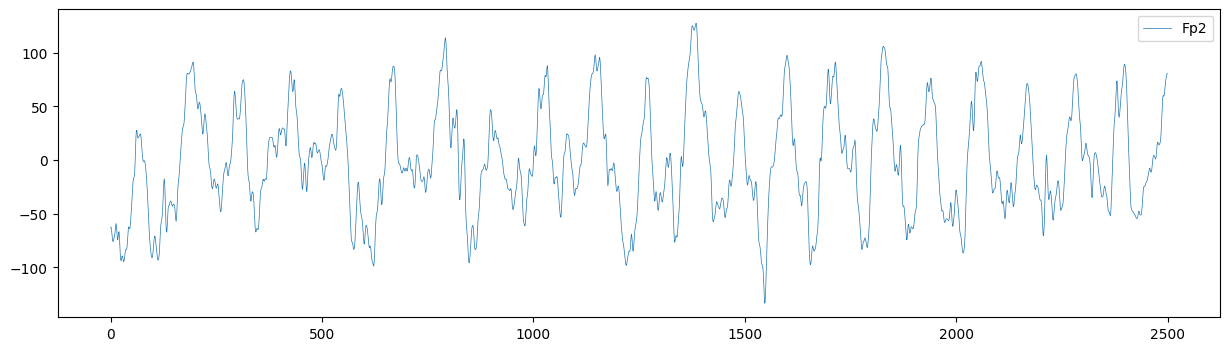

In [65]:
plt.figure(figsize=(15, 4))    


plt.plot(contaminated_fp2, linewidth=0.5, label='Fp2')

plt.legend()

Calculate the Pearson correlation coefficient between the ground truth and the clean sinal after ASR

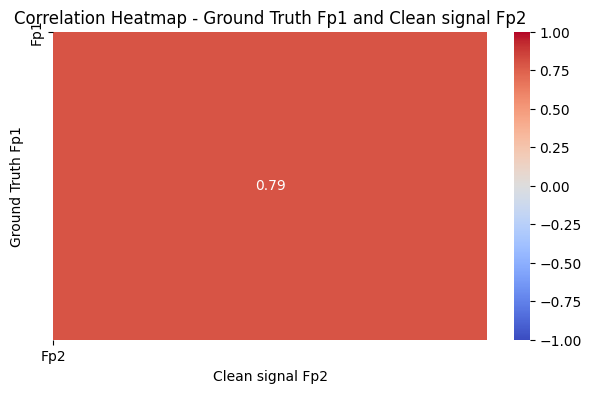

In [66]:
# Calculate the correlation between sources extracted from the origianl signal with the IMU features
matcorr = np.zeros((1, 1))

matcorr[0, 0] = np.corrcoef(z1_single_asr, z2_single_asr)[0, 1]
        
# Visualize the correlation map
plt.figure(figsize=(7, 4))
sns.heatmap(matcorr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Ground Truth Fp1 and Clean signal Fp2')
plt.xlabel('Clean signal Fp2')
plt.ylabel('Ground Truth Fp1')
plt.xticks(np.arange(0, matcorr.shape[1]), labels=['Fp2'])
plt.yticks(np.arange(0, matcorr.shape[0]), labels=['Fp1'])
plt.show()

## Adaptive learning

## Compare single channel ASR with traditional ASR and other methods

### SWT and thresholding for denoising

In [67]:

wavelet = 'db4'
decomposition_level = 5
wt_single = filtered_data.copy()

for i in range(2):
    wt_single[i], _ = filter_sos(wt_single[i], 'bandpass', [5, 40.0], fs, 4)

# Perform Wavelet Transform on both reference and EEG data to decompose them
eeg_wt = wt_single[:eeg_chans, stim_idx:post_stim_idx]
# eeg_wt_z, _ = z_score_normalize(eeg_wt)
coeffs_eeg_wt = [pywt.swt(eeg_wt[i], wavelet, level=decomposition_level) for i in range(eeg_wt.shape[0])]
# Calculate threshold
threshold_value = universal_threshold(np.array(coeffs_eeg_wt[0]))
threshold_eeg_wt = pywt.threshold(coeffs_eeg_wt[0], threshold_value, 'soft')

denoised_eeg = []
for j in range(eeg_chans):
    coeffs_for_reconstruction_swt = [(threshold_eeg_wt[i][1]) for i in range(threshold_eeg_wt.shape[0])]
    denoised_eeg.append(pywt.iswt(coeffs_for_reconstruction_swt, wavelet))


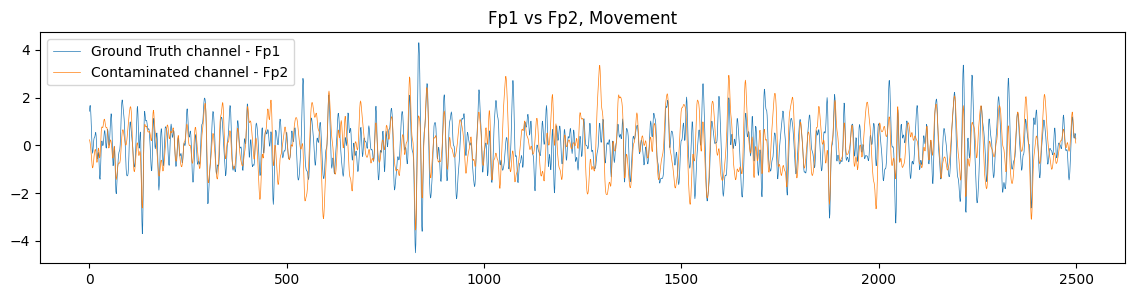

In [68]:
z1_single_wt_threshold, _ = z_score_normalize(wt_single[1, stim_idx+10*fs:stim_idx+20*fs])
z2_single_wt_threshold, _ = z_score_normalize(denoised_eeg[0][10*fs:20*fs])
z3_single_wt_threshold, _ = z_score_normalize(wt_single[0, stim_idx+10*fs:stim_idx+20*fs])

plt.figure(figsize=(14, 3))    
plt.plot(z1_single_wt_threshold, linewidth=0.5, label='Ground Truth channel - Fp1')
plt.plot(z2_single_wt_threshold, linewidth=0.5 ,label='Contaminated channel - Fp2')
plt.title(f'Fp1 vs Fp2, Movement') 
plt.legend()


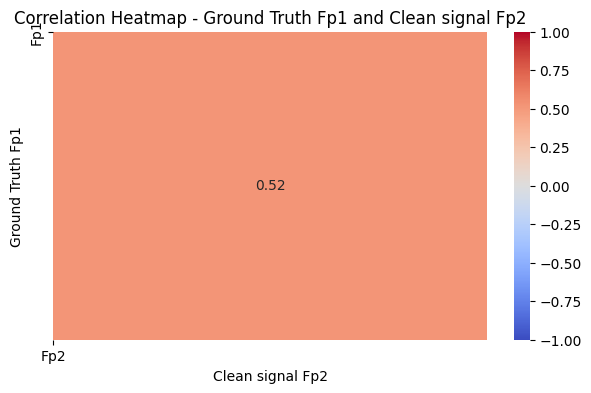

In [69]:
matcorr = np.zeros((1, 1))
matcorr[0, 0] = np.corrcoef(z1_single_wt_threshold, z2_single_wt_threshold)[0, 1]
        
plt.figure(figsize=(7, 4))
sns.heatmap(matcorr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Ground Truth Fp1 and Clean signal Fp2')
plt.xlabel('Clean signal Fp2')
plt.ylabel('Ground Truth Fp1')
plt.xticks(np.arange(0, matcorr.shape[1]), labels=['Fp2'])
plt.yticks(np.arange(0, matcorr.shape[0]), labels=['Fp1'])
plt.show()

### DWT and thresholding for denoising

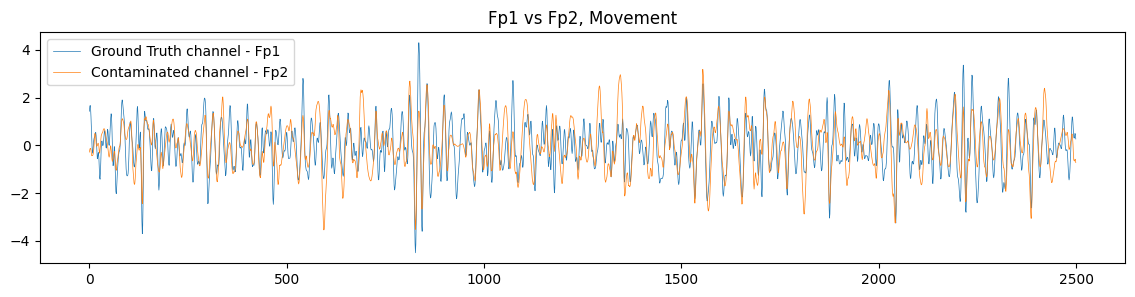

In [70]:
dwt_single = filtered_data.copy()

for i in range(2):
    dwt_single[i], _ = filter_sos(dwt_single[i], 'bandpass', [5, 40.0], fs, 4)

# Perform Wavelet Transform on both reference and EEG data to decompose them
eeg_dwt = dwt_single[:eeg_chans, stim_idx:post_stim_idx]
coeffs_eeg_dwt = pywt.wavedec(eeg_dwt[0], wavelet, level=decomposition_level)
# Flatten the list of arrays into a single array
coeffs_flat = np.hstack([coeff.flatten() for coeff in coeffs_eeg_dwt])
threshold_value_dwt = universal_threshold(coeffs_flat)
threshold_eeg_dwt = [pywt.threshold(arr, threshold_value_dwt, 'soft') for arr in coeffs_eeg_dwt]

denoised_eeg_dwt = pywt.waverec(threshold_eeg_dwt, wavelet)

z1_single_dwt_threshold, _ = z_score_normalize(dwt_single[1, stim_idx+10*fs:stim_idx+20*fs])
z2_single_dwt_threshold, _ = z_score_normalize(denoised_eeg_dwt[10*fs:20*fs])
z3_single_dwt_threshold, _ = z_score_normalize(dwt_single[0, stim_idx+10*fs:stim_idx+20*fs])

plt.figure(figsize=(14, 3))    
plt.plot(z1_single_dwt_threshold, linewidth=0.5, label='Ground Truth channel - Fp1')
plt.plot(z2_single_dwt_threshold, linewidth=0.5 ,label='Contaminated channel - Fp2')
plt.title(f'Fp1 vs Fp2, Movement') 
plt.legend()

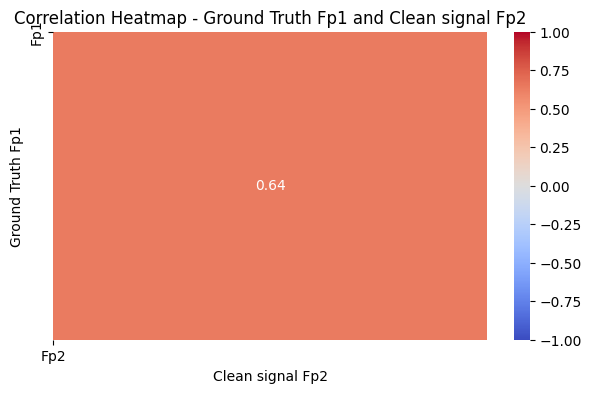

In [71]:
# Calculate the correlation between sources extracted from the origianl signal with the IMU features
matcorr = np.zeros((1, 1))

matcorr[0, 0] = np.corrcoef(z1_single_dwt_threshold, z2_single_dwt_threshold)[0, 1]
        
# Visualize the correlation map
plt.figure(figsize=(7, 4))
sns.heatmap(matcorr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Ground Truth Fp1 and Clean signal Fp2')
plt.xlabel('Clean signal Fp2')
plt.ylabel('Ground Truth Fp1')
plt.xticks(np.arange(0, matcorr.shape[1]), labels=['Fp2'])
plt.yticks(np.arange(0, matcorr.shape[0]), labels=['Fp1'])
plt.show()

### LMS

In [72]:
import padasip as pa

lms_filter = pa.filters.FilterLMS(n=1, mu=0.1, w="random")
# lms_filter = pa.filters.FilterVSLMS_Mathews(n=1, mu=0.1, ro=0.001, w="random")
e, clean, w = lms_filter.run(ref_dat_z.reshape(-1), eeg_dat_z.reshape(eeg_dat_z.shape[1], 1))
z_lms,_ = z_score_normalize(e[10*fs:20*fs])

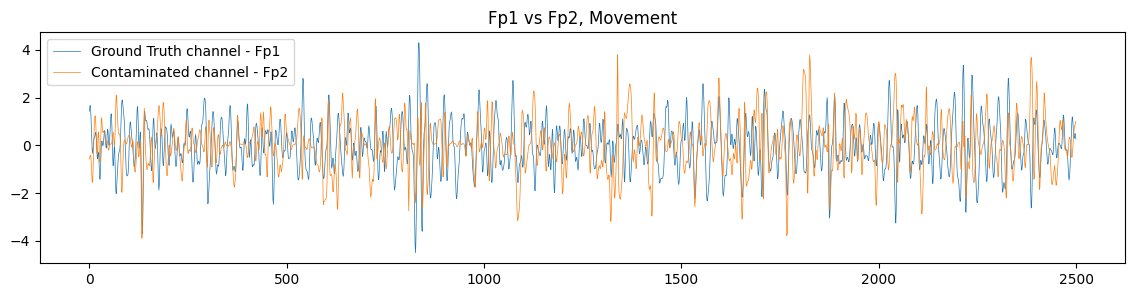

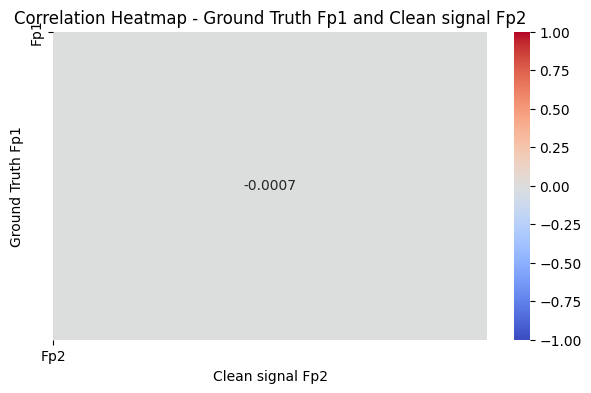

In [73]:
plt.figure(figsize=(14, 3))    
plt.plot(z1_single_dwt_threshold, linewidth=0.5, label='Ground Truth channel - Fp1')
plt.plot(z_lms, linewidth=0.5 ,label='Contaminated channel - Fp2')
plt.title(f'Fp1 vs Fp2, Movement') 
plt.legend()

# Calculate the correlation between sources extracted from the origianl signal with the IMU features
matcorr = np.zeros((1, 1))

matcorr[0, 0] = np.corrcoef(z1_single_dwt_threshold, z_lms)[0, 1]
        
# Visualize the correlation map
plt.figure(figsize=(7, 4))
sns.heatmap(matcorr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Ground Truth Fp1 and Clean signal Fp2')
plt.xlabel('Clean signal Fp2')
plt.ylabel('Ground Truth Fp1')
plt.xticks(np.arange(0, matcorr.shape[1]), labels=['Fp2'])
plt.yticks(np.arange(0, matcorr.shape[0]), labels=['Fp1'])
plt.show()

### RLS

In [74]:
import padasip as pa

lms_filter = pa.filters.FilterRLS(n=1, mu=0.1, w="random")
e, clean, w = lms_filter.run(ref_dat_z.reshape(-1), eeg_dat_z.reshape(eeg_dat_z.shape[1], 1))
z_rls,_ = z_score_normalize(clean[10*fs:20*fs])

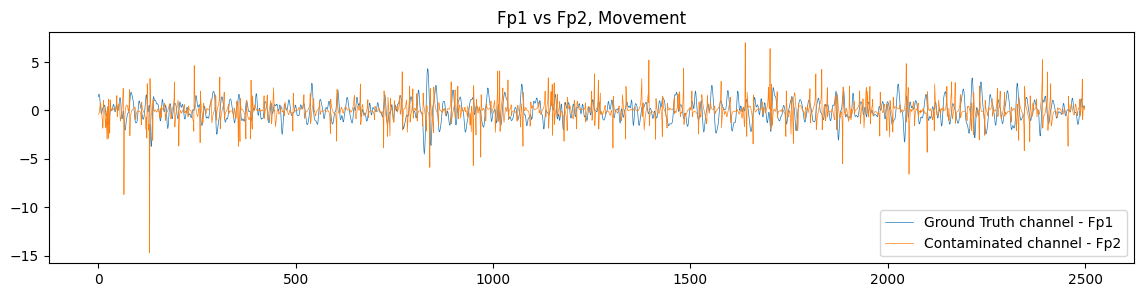

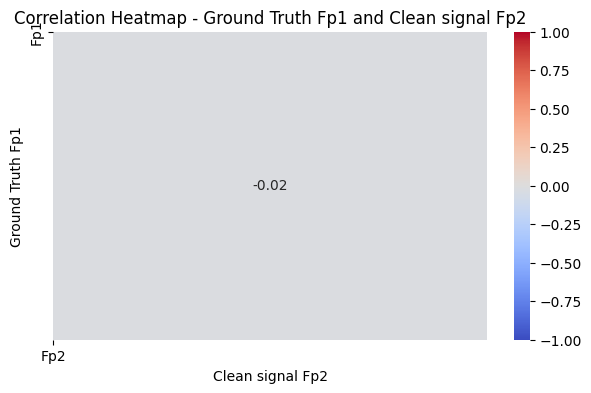

In [75]:
plt.figure(figsize=(14, 3))    
plt.plot(z1_single_dwt_threshold, linewidth=0.5, label='Ground Truth channel - Fp1')
plt.plot(z_rls, linewidth=0.5 ,label='Contaminated channel - Fp2')
plt.title(f'Fp1 vs Fp2, Movement') 
plt.legend()

# Calculate the correlation between sources extracted from the origianl signal with the IMU features
matcorr = np.zeros((1, 1))

matcorr[0, 0] = np.corrcoef(z1_single_dwt_threshold, z_rls)[0, 1]
        
# Visualize the correlation map
plt.figure(figsize=(7, 4))
sns.heatmap(matcorr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Ground Truth Fp1 and Clean signal Fp2')
plt.xlabel('Clean signal Fp2')
plt.ylabel('Ground Truth Fp1')
plt.xticks(np.arange(0, matcorr.shape[1]), labels=['Fp2'])
plt.yticks(np.arange(0, matcorr.shape[0]), labels=['Fp1'])
plt.show()

### NLMS

In [76]:
import padasip as pa

nlms_filter = pa.filters.FilterNLMS(n=1, mu=0.1, w="random")
e, clean, w = nlms_filter.run(ref_dat_z.reshape(-1), eeg_dat_z.reshape(eeg_dat_z.shape[1], 1))
z_nlms,_ = z_score_normalize(clean[10*fs:20*fs])

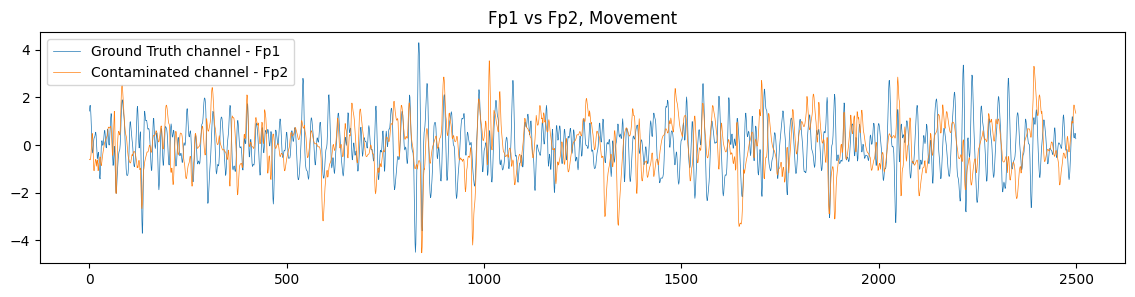

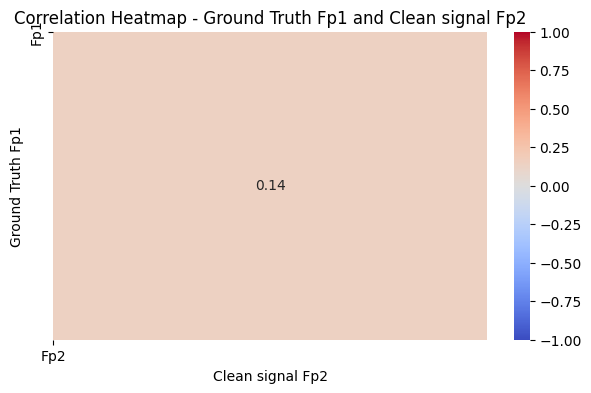

In [77]:
plt.figure(figsize=(14, 3))    
plt.plot(z1_single_dwt_threshold, linewidth=0.5, label='Ground Truth channel - Fp1')
plt.plot(z_nlms, linewidth=0.5 ,label='Contaminated channel - Fp2')
plt.title(f'Fp1 vs Fp2, Movement') 
plt.legend()

# Calculate the correlation between sources extracted from the origianl signal with the IMU features
matcorr = np.zeros((1, 1))

matcorr[0, 0] = np.corrcoef(z1_single_dwt_threshold, z_nlms)[0, 1]
        
# Visualize the correlation map
plt.figure(figsize=(7, 4))
sns.heatmap(matcorr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Ground Truth Fp1 and Clean signal Fp2')
plt.xlabel('Clean signal Fp2')
plt.ylabel('Ground Truth Fp1')
plt.xticks(np.arange(0, matcorr.shape[1]), labels=['Fp2'])
plt.yticks(np.arange(0, matcorr.shape[0]), labels=['Fp1'])
plt.show()

### SSA

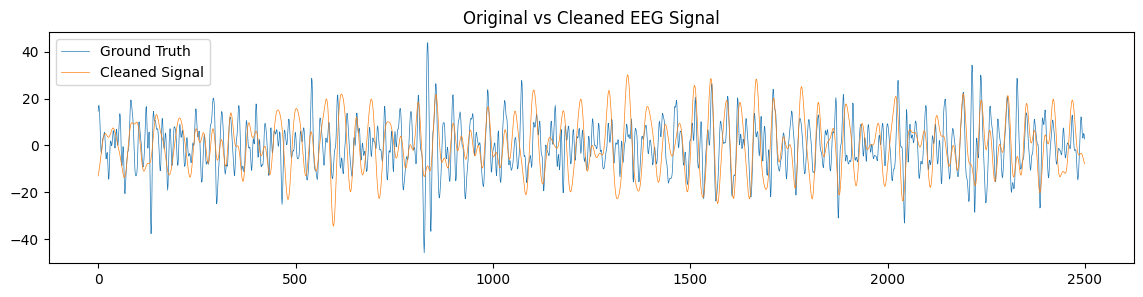

In [78]:

eeg_ssa = asr_single[0, stim_idx:post_stim_idx].reshape(eeg_dat_z.shape[1], 1)

import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis

# Assuming eeg_dat_z is your contaminated EEG signal (1D numpy array)
n_samples = 1  # We have a single EEG time series
n_timestamps = len(eeg_ssa)  # Length of your EEG signal

# Reshape the EEG data to fit the pyts SSA function input requirements
X = eeg_ssa.reshape(n_samples, n_timestamps)

# Define the window size for SSA - Choose based on your signal's characteristics
# Since fs = 250Hz, choose a window size that captures enough of the EEG's frequency components
window_size = int(250 * 0.5)  # Example: half a second window

# Singular Spectrum Analysis
# The groups parameter should be defined based on exploratory analysis or domain knowledge
# Here, we start with a simple division but you might need to adjust it
groups = [np.arange(i, i + 5) for i in range(0, window_size - 5, 5)]

ssa = SingularSpectrumAnalysis(window_size=window_size, groups=groups)
X_ssa = ssa.fit_transform(X)

# Reconstruct the signal without noise components
# This requires you to exclude the groups associated with noise or artifacts
# Assuming, based on visual inspection, that components 2 and 3 are noise/artifacts
cleaned_signal_ssa = np.sum(X_ssa[0, [0]], axis=0)  # Change [0] based on which components to keep

plt.figure(figsize=(14, 3))
plt.plot(asr_single[1, stim_idx+10*fs:stim_idx+20*fs], linewidth=0.5, label='Ground Truth')
plt.plot(cleaned_signal_ssa[10*fs:20*fs], linewidth=0.5, label='Cleaned Signal')
plt.legend()
plt.title('Original vs Cleaned EEG Signal')
plt.show()



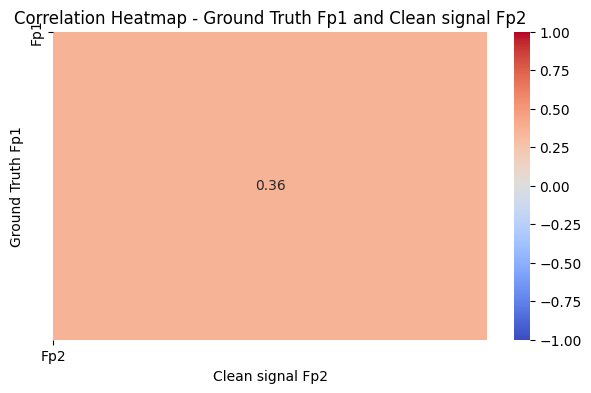

In [79]:

# Calculate the correlation between sources extracted from the origianl signal with the IMU featurematcorr = np.zeros((1, 1))

matcorr[0, 0] = np.corrcoef(z1_single_dwt_threshold, cleaned_signal_ssa[10*fs:20*fs])[0, 1]
        
# Visualize the correlation map
plt.figure(figsize=(7, 4))
sns.heatmap(matcorr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Ground Truth Fp1 and Clean signal Fp2')
plt.xlabel('Clean signal Fp2')
plt.ylabel('Ground Truth Fp1')
plt.xticks(np.arange(0, matcorr.shape[1]), labels=['Fp2'])
plt.yticks(np.arange(0, matcorr.shape[0]), labels=['Fp1'])
plt.show()

## SNR calculation

[ 5.04107224 -1.26268077  0.7511587  -1.69426058 -0.68456714 -0.90682209
 -0.23890621]


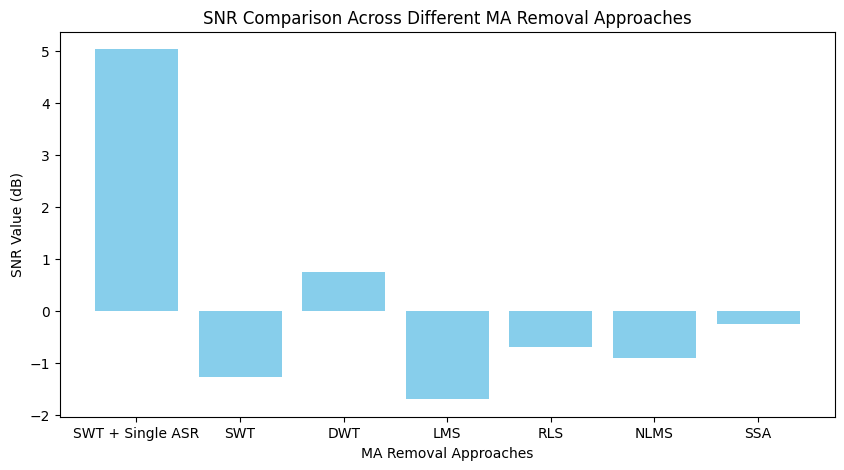

In [80]:
ground_truth = asr_single[1, stim_idx+10*fs:stim_idx+20*fs]
contaminated = asr_single[0, stim_idx+10*fs:stim_idx+20*fs]

asr = convert_back_to_original_scale(z2_single_asr, ground_truth_z_revert)
lms = convert_back_to_original_scale(z_lms, ground_truth_z_revert)
rls = convert_back_to_original_scale(z_rls, ground_truth_z_revert)
nlms = convert_back_to_original_scale(z_nlms, ground_truth_z_revert)

clean_ma = [asr, denoised_eeg[0][10*fs:20*fs], denoised_eeg_dwt[10*fs:20*fs], lms, rls, nlms, cleaned_signal_ssa[10*fs:20*fs]]


# convert back to the original scale
# clean_ma[0] = convert_back_to_original_scale(clean_ma[0], ground_truth_z_revert)
# clean_ma[1] = convert_back_to_original_scale(clean_ma[1], ground_truth_z_revert)
# clean_ma[2] = convert_back_to_original_scale(clean_ma[2], ground_truth_z_revert)

# for idx in range(len(clean_ma)):
#     clean_ma[idx] = convert_back_to_original_scale(clean_ma[idx], ground_truth_z_revert)
    
def calculate_power(signal):
    return np.mean(np.square(signal))
    # return np.var(signal)

def calculate_absolute_power(signal, fs):
    # Calculate the FFT of the signal
    fft_vals = np.fft.rfft(signal)
    
    # Calculate the frequencies for the FFT values
    fft_freq = np.fft.rfftfreq(len(signal), 1 / fs)
    
    # Calculate the PSD as the squared magnitude of the FFT values
    psd_vals = np.abs(fft_vals) ** 2
    
    # Isolate the power within the 1 Hz to 40 Hz range
    relevant_indices = np.where((fft_freq >= 2) & (fft_freq <= 50))[0]
    absolute_power = np.sum(psd_vals[relevant_indices])
    
    return absolute_power


def calculate_snr(clean_signal, ground_truth, contaminated):
    power_clean_signal = calculate_absolute_power(clean_signal,250)
    power_noise = calculate_absolute_power(contaminated - ground_truth,250)
    
    # power_clean_signal = calculate_power(clean_signal)
    # power_noise = calculate_power(contaminated - ground_truth)
    
    snr_db = 10 * np.log10(power_clean_signal / power_noise) if power_noise > 0 else float('inf')
    
    return snr_db


snr_values_asr = [calculate_snr(ground_truth, ground_truth, cleaned_signal) for cleaned_signal in clean_ma]
snr_values_art = calculate_snr(ground_truth, ground_truth, contaminated)

# MA removal approach names for the x-axis
ma_removal_approaches = ['SWT + Single ASR', 'SWT', 'DWT', 'LMS', 'RLS', 'NLMS', 'SSA']

print(snr_values_asr - snr_values_art)

# Plotting the SNR values
plt.figure(figsize=(10, 5))
plt.bar(ma_removal_approaches, snr_values_asr - snr_values_art, color='skyblue')
# plt.bar(ma_removal_approaches, snr_values_asr, color='skyblue')

plt.xlabel('MA Removal Approaches')
plt.ylabel('SNR Value (dB)')
plt.title('SNR Comparison Across Different MA Removal Approaches')
plt.show()

## RMSE, MAE, SDR

In [81]:
def calculate_rmse(ground_truth, cleaned_signal):
    return np.sqrt(np.mean((ground_truth - cleaned_signal) ** 2))

def calculate_mae(ground_truth, cleaned_signal):
    return np.mean(np.abs(ground_truth - cleaned_signal))

def calculate_sdr(ground_truth, cleaned_signal):
    signal_power = np.sum(ground_truth ** 2)
    distortion_power = np.sum((cleaned_signal - ground_truth) ** 2)
    sdr = 10 * np.log10(signal_power / distortion_power) if distortion_power > 0 else float('inf')
    return sdr

# Example usage for a list of cleaned signals
rmse_values = [calculate_rmse(ground_truth, cleaned_signal) for cleaned_signal in clean_ma]
mae_values = [calculate_mae(ground_truth, cleaned_signal) for cleaned_signal in clean_ma]
sdr_values = [calculate_sdr(ground_truth, cleaned_signal) for cleaned_signal in clean_ma]

print(rmse_values)
print(mae_values)
print(sdr_values)


[6.553649956656037, 13.539213214676902, 10.748018487135818, 14.417402041194967, 14.556283769385063, 13.346084898977635, 12.035651626748889]
[5.334418994430221, 10.691013185770892, 8.527047170513828, 11.148653065098795, 10.823459920676743, 10.40068568008566, 9.512982204685947]
[3.834799173241784, -2.4674045546202397, -0.46210409930939383, -3.0132761896266054, -3.096546272054514, -2.342613668268135, -1.4449281748790783]


## R-squre, SD, DR

[0.6292076156087508, 0.27124374325716005, 0.40979444756297834, 4.880519109095968e-07, 0.0004028358500136692, 0.020304610006468802, 0.131159625553324]
[18.698310985416942, 27.097738468524177, 41.36794170465086, 41.235358865631575, 65.98743357018145, 45.555360200502136, 35.95512096458363]


C:\Users\Nhan\AppData\Local\Temp\ipykernel_63496\1743852764.py:120: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


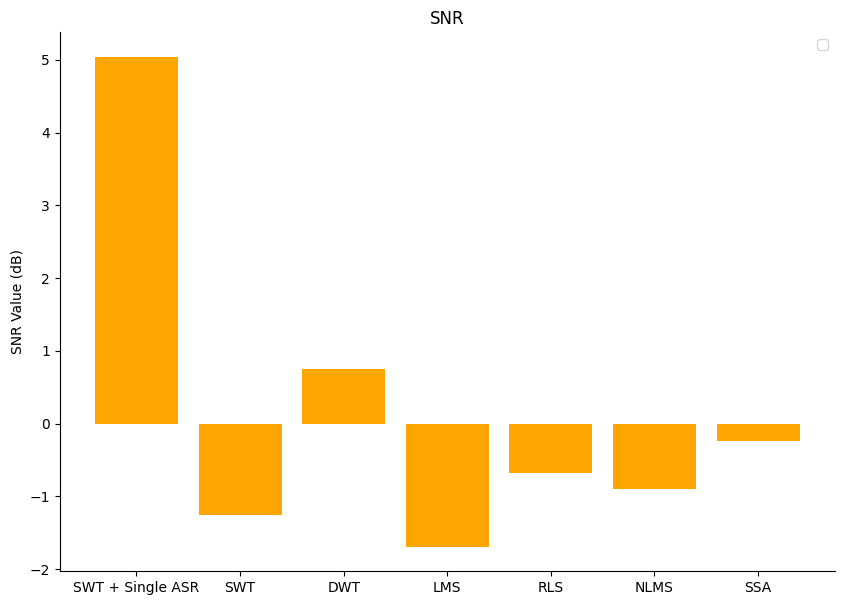

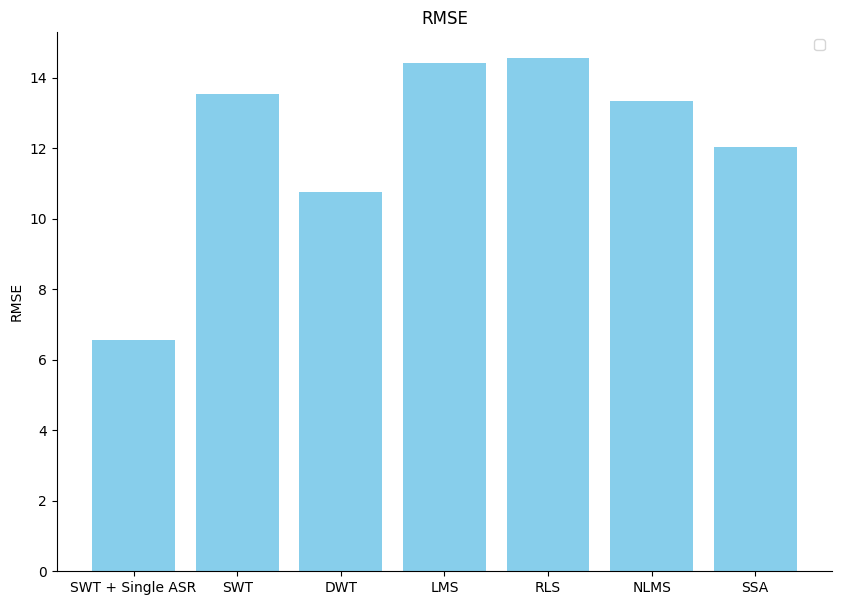

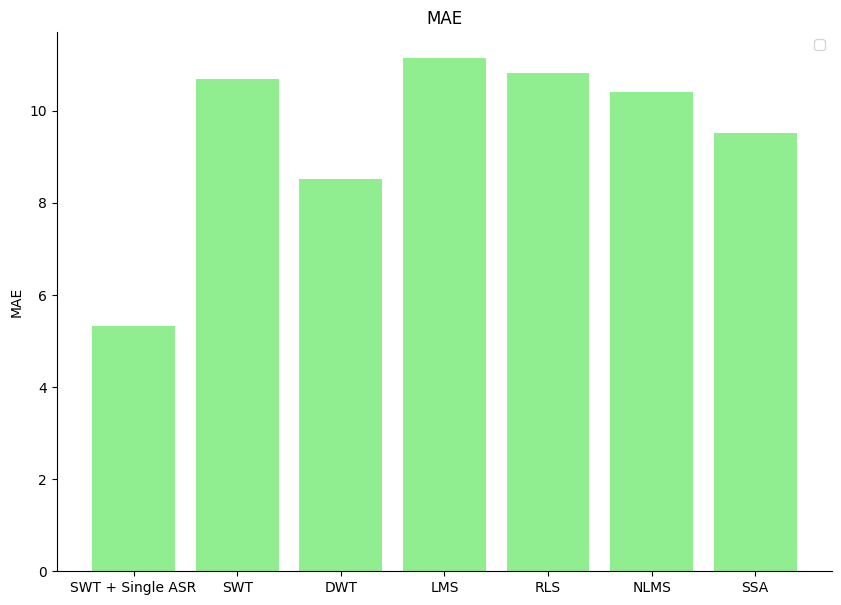

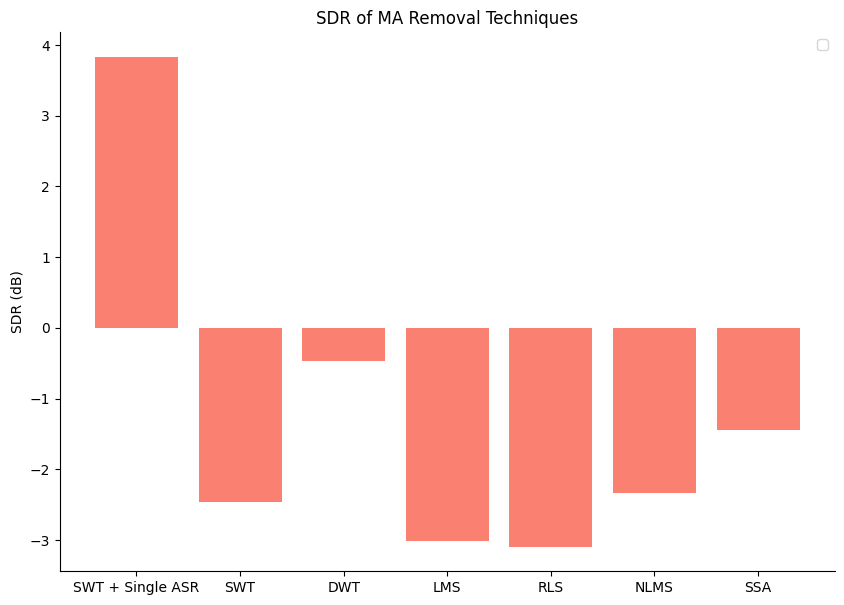

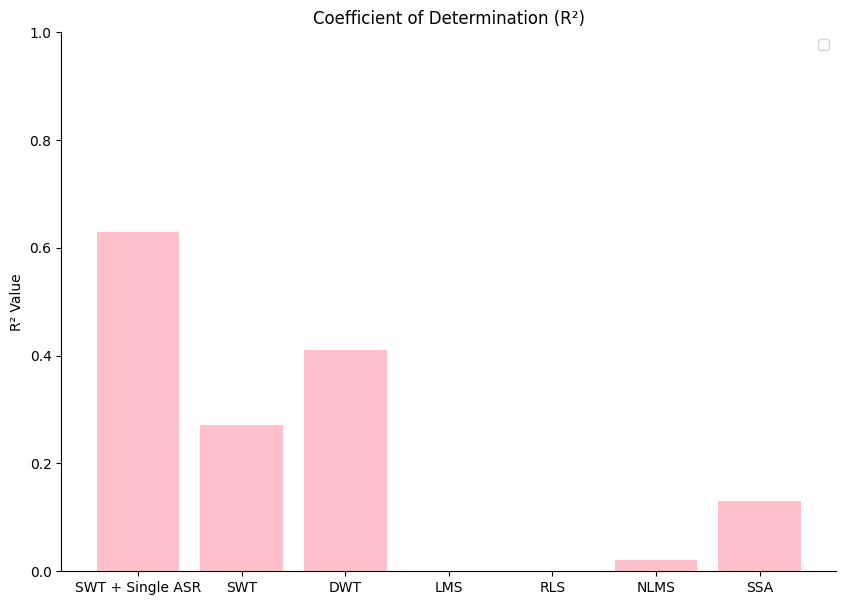

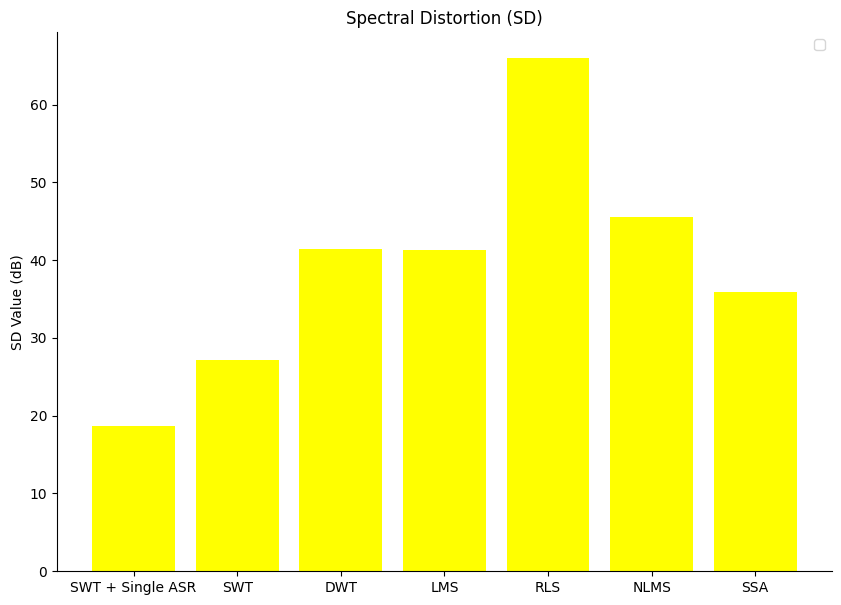

In [82]:
import numpy as np
from scipy.signal import welch

def calculate_coefficient_of_determination(ground_truth, cleaned_signal):
    # Calculate the R-squared metric
    correlation_matrix = np.corrcoef(ground_truth, cleaned_signal)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy**2
    return r_squared

def calculate_spectral_distortion(ground_truth, cleaned_signal, fs):
    # Calculate the Power Spectral Densities (PSDs) using Welch's method
    f_ground_truth, psd_ground_truth = welch(ground_truth, fs=fs)
    f_cleaned_signal, psd_cleaned_signal = welch(cleaned_signal, fs=fs)

    # Interpolate the PSD of the cleaned signal to match the frequency bins of the ground truth PSD
    psd_cleaned_interp = np.interp(f_ground_truth, f_cleaned_signal, psd_cleaned_signal)

    # Avoid division by zero and log of zero
    psd_ground_truth += 1e-10
    psd_cleaned_interp += 1e-10

    # Calculate the Spectral Distortion (SD)
    spectral_distortion = np.sqrt(np.mean((10 * np.log10(psd_cleaned_interp / psd_ground_truth))**2))
    return spectral_distortion


r_squared_results = [calculate_coefficient_of_determination(ground_truth, signal) for signal in clean_ma]
sd_results = [calculate_spectral_distortion(ground_truth, signal, fs) for signal in clean_ma]

print(r_squared_results)
print(sd_results)

# Printing example results
plt.figure(figsize=(10, 7))    
# SNR
plt.bar(ma_removal_approaches, snr_values_asr - snr_values_art, color='orange')
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title('SNR')
plt.ylabel('SNR Value (dB)')
plt.legend(loc='upper right') 
# plt.xticklabels(ma_removal_approaches, rotation=45, ha="right")

# RMSE
plt.figure(figsize=(10, 7))    
# SNR
plt.bar(ma_removal_approaches, rmse_values, color='skyblue')
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title('RMSE')
plt.ylabel('RMSE')
plt.legend(loc='upper right') 
# plt.xticklabels(ma_removal_approaches, rotation=45, ha="right")


# MAE
plt.figure(figsize=(10, 7))    
plt.bar(ma_removal_approaches, mae_values, color='lightgreen')
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title('MAE')
plt.ylabel('MAE')
plt.legend(loc='upper right') 
# plt.xticklabels(ma_removal_approaches, rotation=45, ha="right")


# SDR
plt.figure(figsize=(10, 7))    
plt.bar(ma_removal_approaches, sdr_values, color='salmon')
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title('SDR of MA Removal Techniques')
plt.ylabel('SDR (dB)')
plt.legend(loc='upper right') 
# plt.xticklabels(ma_removal_approaches, rotation=45, ha="right")

# R^2
plt.figure(figsize=(10, 7))    
plt.bar(ma_removal_approaches, r_squared_results, color='pink')
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title('Coefficient of Determination (R²)')
plt.ylabel('R² Value')
plt.legend(loc='upper right') 
plt.ylim(0, 1)
# plt.xticklabels(ma_removal_approaches, rotation=45, ha="right")


# Plot Spectral Distortion values
plt.figure(figsize=(10, 7))    
plt.bar(ma_removal_approaches, sd_results, color='yellow')
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title('Spectral Distortion (SD)')
plt.ylabel('SD Value (dB)')
plt.legend(loc='upper right') 
# plt.xticklabels(ma_removal_approaches, rotation=45, ha="right")


# Adjust layout to prevent overlap
fig.tight_layout()
